In [1]:
import warnings

warnings.simplefilter(action="ignore")

import functools
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
import os
import time
import torch
import torchnet as tnt

import torch.nn as nn

import matplotlib

# Weird behavior: loading twice in cell appears to remove an elsewise occuring error.
for i in range(2):
    try:
        matplotlib.use("TkAgg")  # rerun this cell if an error occurs.
    except:
        print("!")

print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()

# We import from other files

import sys
sys.path.append("/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/")

from config import args
from utils.useful_functions import *
from data_loader.loader import *
from utils.load_las_data import load_all_las_from_folder, open_metadata_dataframe
from model.loss_functions import *
from model.accuracy import *
from em_gamma.get_gamma_parameters_em import *
from model.train import train_full
import laspy
print("Everything is imported")


print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()

False
Arguments were imported in PROD mode
Everything is imported
False


In [139]:
from laspy.file import File

# Parse LAS files
las = File('/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/data/placettes_dataset/las_classes/2021_POINT_OBS53.las', mode="r")
x_las = las.X / 100  # we divide by 100 as all the values in las are in cm
y_las = las.Y / 100
z_las = las.Z / 100
r = las.Red
g = las.Green
b = las.Blue
nir = las.nir
intensity = las.intensity
return_nb = las.return_num
points_nparray = np.asarray(
    [x_las, y_las, z_las, r, g, b, nir, intensity, return_nb]
).T

In [140]:
z_las

array([490.71, 490.75, 490.78, ..., 492.97, 493.07, 493.28])

In [141]:
import math
def scaled_scan_angle_to_degree(scan_angle, DIVISION_RATIO = 10000):
    """ Convert las scan angle info, which are minutes divided by 10000,  
    """
    DEGREE_BY_MINUTE = 1.0 / ((math.pi / (180 * 60)) / (math.pi / 180))
    degrees = scan_angle / DIVISION_RATIO * DEGREE_BY_MINUTE
    return degrees


In [142]:
help(np.)

SyntaxError: invalid syntax (<ipython-input-142-d0ec47cc9383>, line 1)

<IPython.core.display.Javascript object>


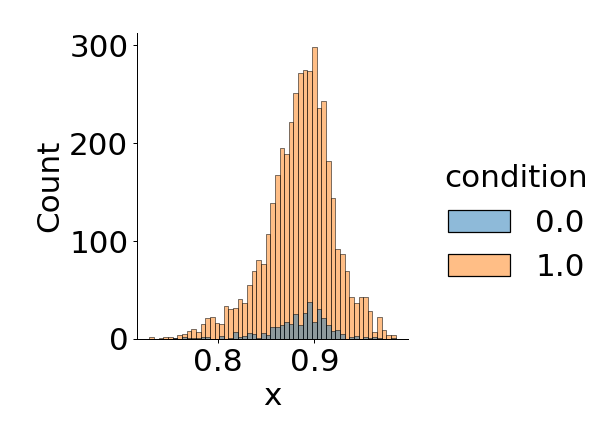

In [143]:
%matplotlib notebook
from utils.load_las_data import normalize_z_with_minz_in_a_radius
cloud = normalize_z_with_minz_in_a_radius(points_nparray, 1.5)


import seaborn as sns
condition = cloud[:,2]>0.2
x = (300000+las.intensity) / (300000+las.red+las.blue+las.green)
df = pd.DataFrame(data=np.stack([x,condition]).T, columns = ["x","condition"])
sns.displot(data=df, x = "x",hue = "condition")
plt.show()

<IPython.core.display.Javascript object>


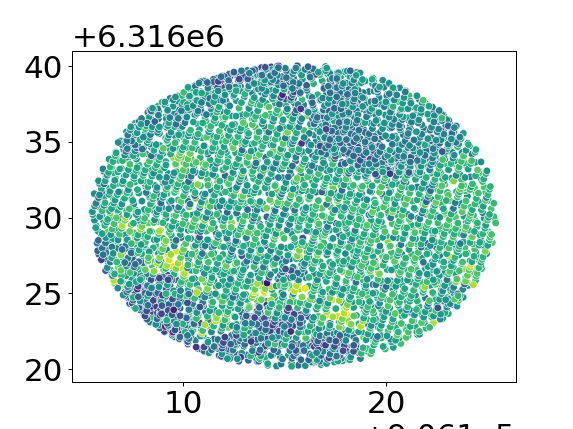

In [149]:
import glob

pl_re = "/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/data/placettes_dataset/las_classes/*.las"
for f in glob.glob(pl_re):
    if "2021_POINT_OBS53.las" in f :
        las = File(f, mode="r")
        x_las = las.X / 100  # we divide by 100 as all the values in las are in cm
        y_las = las.Y / 100
        z_las = las.Z / 100
        r = las.Red
        g = las.Green
        b = las.Blue
        nir = las.nir
        intensity = las.intensity
        return_nb = las.return_num
        points_nparray = np.asarray(
            [x_las, y_las, z_las, r, g, b, nir, intensity, return_nb]
        ).T
        # SHOW
        plt.figure()
        condition = las.return_num == las.num_returns
        x = (300000 + las.intensity) / (300000 + las.red + las.blue + las.green)
        x = (300000 + las.intensity) / (300000 + las.nir)
        df = pd.DataFrame(data=np.stack([x, condition]).T, columns=["x", "condition"])
        sns.scatterplot(
            x=las.x,
            y=las.y,
            c=x,
        )

        # sns.scatterplot(data=df, x = "x",hue = "condition", c=las.classification)
        plt.show()

In [113]:
def plot_norm_impact(cloud, cloud_norm, title = "", output_path = "./placeholder.png"):
    cloud[:,2] = cloud[:,2] - np.min(cloud[:,2])
    
    fig = plt.figure(figsize=plt.figaspect(0.8) * 2.5)
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    fig.suptitle(title)

    # without norm
    ax = fig.add_subplot(2, 2, 1, projection="3d")
    ax.scatter3D(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=cloud[:, 2] + 0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=0., azim=0)

    ax = fig.add_subplot(2, 2, 3)
    sns.distplot(cloud[:,2],ax=ax, kde=False)


    # with norm
    cloud_norm[:,2] = cloud_norm[:,2] - np.min(cloud_norm[:,2])
    ax = fig.add_subplot(2, 2, 2, projection="3d")
    ax.scatter3D(cloud_norm[:, 0], cloud_norm[:, 1], cloud_norm[:, 2], c=cloud_norm[:, 2] + 0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=0., azim=0)

    ax = fig.add_subplot(2, 2, 4)
    sns.distplot(cloud_norm[:,2],ax=ax, kde=False)

    plt.tight_layout()
    plt.savefig(output_path, dpi = 100, facecolor=fig.get_facecolor(), edgecolor='none')

<IPython.core.display.Javascript object>


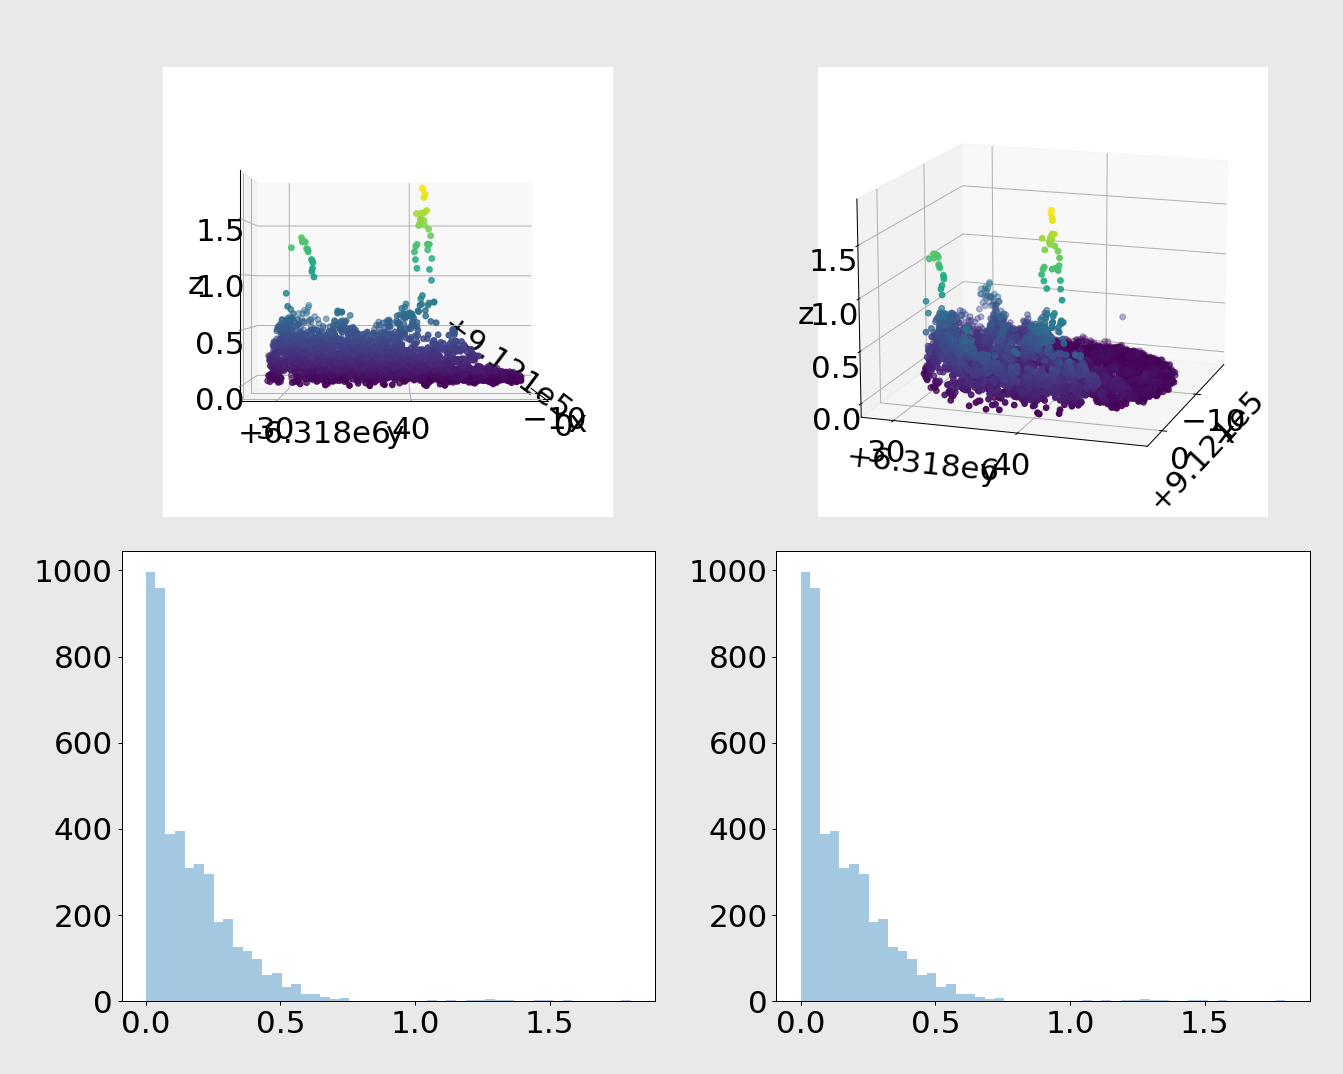

In [114]:
from utils.load_las_data import normalize_z_with_minz_in_a_radius
cloud = normalize_z_with_minz_in_a_radius(points_nparray, 1.5)
plot_norm_impact(points_nparray, cloud)

array([[ True,  True, False, False, False],
       [ True,  True, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

In [16]:
import numpy.ma as ma 
amask = ma.masked_invalid(a)
a[amask>0.5] = 1
a

array([[       nan,        nan, 1.        , 1.        , 0.15601864],
       [       nan,        nan, 1.        , 1.        , 1.        ],
       [0.02058449, 1.        , 1.        , 0.21233911, 0.18182497],
       [0.18340451, 0.30424224, 1.        , 0.43194502, 0.29122914],
       [1.        , 0.13949386, 0.29214465, 0.36636184, 0.45606998]])

In [17]:
bool_mat = (amask>0.5) * 1.
bool_mat[amask.mask] = np.nan
bool_mat.data

array([[nan, nan,  1.,  1.,  0.],
       [nan, nan,  1.,  1.,  1.],
       [ 0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.]])

In [108]:
amask.mask

array([[ True,  True, False, False, False],
       [ True,  True, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])